# 7.2 Kernel methods in practice
In the current exercise, we will apply the concepts learned about kernel-methods using 4 toy datasets : moons, circles, blobs, and swiss roll. 

__Task__: Using the kernels available in the support vector machine (SVM) implementation found in scikit learn (linear, polynomial, Gaussian, or sigmoid), find the kernel and the corresponding parameter for which SVM achieves the best classification performance. Specifically, experiment with the value of the $\gamma$ parameter, which controls the influence of each of the training samples in the kernel-projection, and therefore, the bias introduced by the kernel used. For further information, see the [scikit learning documentation](http://scikit-learn.org/stable/modules/svm.html#kernel-functions) about the kernels used. Leave the other parameters, as the regularization strength $C$ and the degree of the polynomial kernel fixed.

__Hint 1__: Implement a grid search to find the optimal $\gamma$ value for each of the kernels.

__Hint 2__: Don't forget to use an adequate crossvalidation framework to avoid overfitting.

__Q 7.2.1__ For each of the datasets, what is the kernel with which SVM achieves the best classification performance? What is the corresponding $\gamma$ value?

__Task__: For each of the kernels studied above, find the corresponding K-PCA projection using the same kernel parameters. Visualize the achieved projection and compare the result with projects resulting from using different $\gamma$ values.

__Q 7.2.2__ For each of the datasets, what is the kernel with which the data has the best separability (visual inspection)? What is the corresponding $\gamma$ value? Does the kernel and the $\gamma$ values correspond to the ones for which the performance on __Q 7.2.1__ was the highest?

__Q 7.2.3__ How many components yield K-PCA? How and why is it different from the number of components delivered by PCA?

__BONUS__: Scikit learn provides a method to automatically perform a grid search and find the optimal parameters for a given kernel when training a SVM. Find and use the mentioned method to find the optimal set of parameters for each of the Kernels and datasets. Are the $\gamma$ values the you found for __Q 7.2.1__  and __Q 7.2.2__  similar to the ones yield by the automatic grid search function provided by scikit learn?

Kernel: linear
Kernel: rbf
Kernel: poly
Kernel: sigmoid
Kernel: linear
Kernel: rbf
Kernel: poly
Kernel: sigmoid
Kernel: linear
Kernel: rbf
Kernel: poly
Kernel: sigmoid
Kernel: linear
Kernel: rbf
Kernel: poly
Kernel: sigmoid


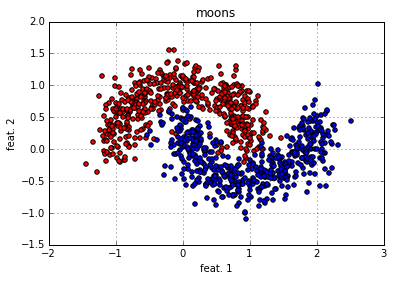

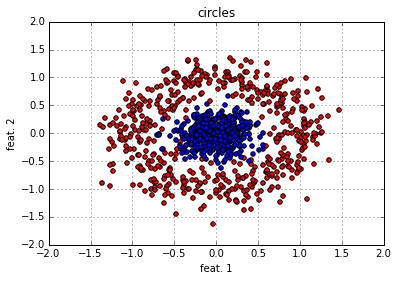

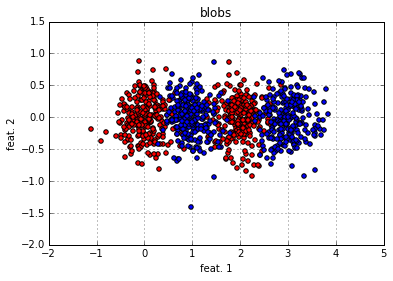

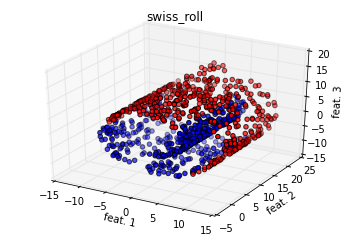

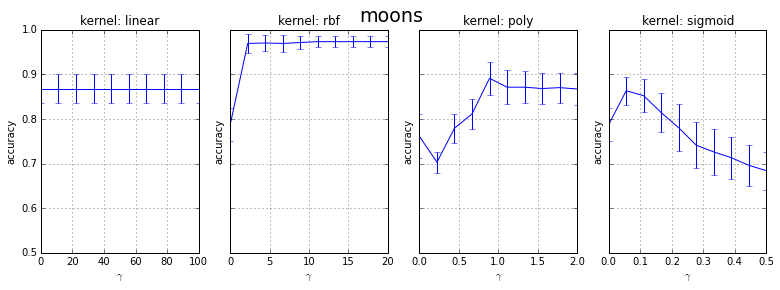

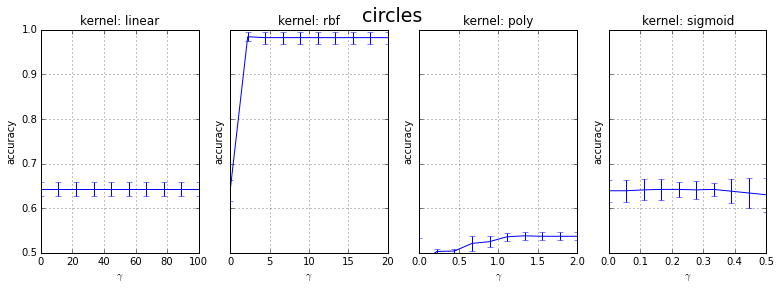

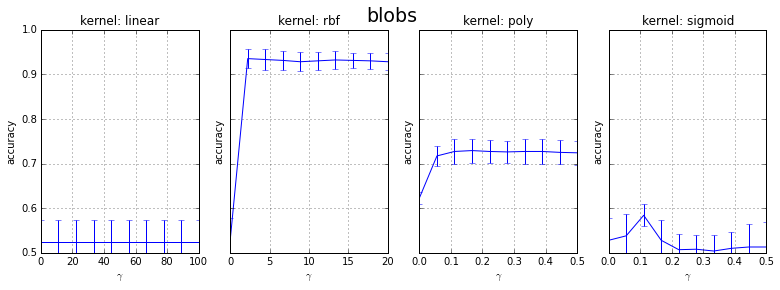

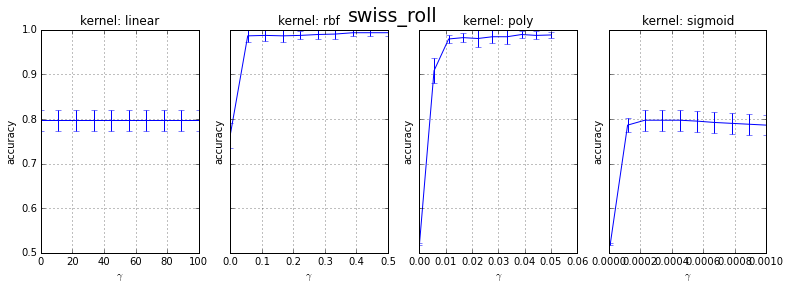

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

from sklearn import datasets
from sklearn import model_selection
from sklearn.preprocessing import normalize
from sklearn.decomposition import KernelPCA
from sklearn import svm

def scatter_plotDataset(fig,x,y):
    colors = ['r','b']   
    if x.shape[1] == 2:        
        ax = fig.add_subplot(111)
        for idx_class in range(2):
            ax.scatter(x[y==idx_class,0],x[y==idx_class,1],
                     c=colors[idx_class])
    elif x.shape[1] == 3:        
        ax = fig.add_subplot(111, projection='3d')
        for idx_class in range(2):
            cclass = y==idx_class
            ax.scatter(x[cclass,0],x[cclass,1],x[cclass,2],
                     c=colors[idx_class])
            ax.set_zlabel('feat. 3')
    ax.set_xlabel('feat. 1')
    ax.set_ylabel('feat. 2')
    return ax

# load data
datasets = {'moons': [],
           'circles': [],
           'blobs': [],
           'swiss_roll': [],}
for key, value in datasets.items():
    fname = os.path.join('datasets',key+'.data')
    x = np.loadtxt(fname)
    fname = os.path.join('datasets',key+'.labels')
    y = np.loadtxt(fname)
    fig = plt.figure()
    plt.grid()
    ax = scatter_plotDataset(fig,x,y)
    ax.set_title(key)   
    # print(y)
    datasets[key] = (x,y) # (immutable tuple of 2 arrays) shape X = (1000,2) / (1000,3) für SwissRoll shape y (1000,) containing 0,1
    
# test 4  kernels on each of the 4 Datasets --> 4 x 4 dictionary containing 
# the kernels, the y_pred, accuracy, 
# for each enty run cross validation over 10 gammas, evaluate and plot accuracy

gamma_ranges = dict() #s.u. eigentlich ein dict von vier dicts, als dict initialisiert, damit unten zuordnung richtig interpretiert
n_eval = 10 # number of gamma values per interval


# 4 x 4 dictionary containing array of 20 scores for each gamma
gamma_ranges['moons'] = {'linear': [1e-5,100],   # avoid zeros --> 1e-5
                    'rbf': [1e-5,20],
                    'poly': [1e-5,2],
                    'sigmoid': [1e-5,0.5]}
gamma_ranges['circles'] = { 'linear': [1e-5,100],
                    'rbf': [1e-5,20],
                    'poly': [1e-5,2],
                    'sigmoid': [1e-5,0.5]}
gamma_ranges['blobs'] = {'linear': [1e-5,100],
                    'rbf': [1e-5,20],
                    'poly': [1e-5,0.5],
                    'sigmoid': [1e-5,0.5]}
gamma_ranges['swiss_roll'] = {'linear': [1e-5,100],
                    'rbf': [1e-5,0.5],
                    'poly': [1e-5,0.05],
                    'sigmoid': [1e-5,0.001]}


kernels = ['linear','rbf','poly','sigmoid']

# Set general options (when using polynomial kernel, use degree 5)
# eigentlich sollte auch mit c experimentiert werden
# When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: 
# C and gamma. The parameter C, common to all SVM kernels, trades off misclassification of training examples against 
# simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
# arguments to pass to svm function
kernel_opts = {'kernel': '', 'degree': 5,  'C': 1.0}   

# global helper variables
scores_overall = dict()
scores_overallErrors = dict()



for key, value in datasets.items():     
    scores_cKernel = []  
    scores_cKernelError = []
    x, y = value  #via dictionary übergebene Datensätze

    # prepare for plot with 1 row, 4 columns, one for each Kernel, figsize is for the ensemble
    # shared y axis sharex, sharey : bool or {‘none’, ‘all’, ‘row’, ‘col’}, default: False
    f, axes = plt.subplots(1, len(kernels), sharey=True, figsize = (13,4))

    for idx_kernel, cKernel in enumerate(kernels):   
        #enumerate installiert idx_kernel als Zähler, während mit ckernel durch "kernels" gebrowst wird:['linear','rbf','poly','sigmoid']
        print('Kernel: '+cKernel)   #concatenation
        kernel_opts['kernel'] = cKernel   # bastle Argument für Parameterübergabe in SciKit Function zusammen
        scores_cGamma = []
        scores_cGammaErrors = []
        # gammas array von gleichmäßig zwischen 0 und 100 verteilten Zahlen, Werte aus  gamma_ranges dict
        gammas = np.linspace(gamma_ranges[key][cKernel][0],
                             gamma_ranges[key][cKernel][1],
                             num=n_eval)    

        # walk throug gamma grid, 
        for c_gamma in gammas:
            kernel_opts['gamma'] = c_gamma  #gamma wird als zusätzlicher dict eintrag drangehängt
            #z.B. {'kernel': 'linear', 'degree': 5, 'gamma': 5.263167368421052}
            clf = svm.SVC(**kernel_opts)  #hand over variable List of arguments in Form of dictionary, get handle on classifier
            # apply classifiert on currend data_set, using Crossvalidation, 10_fold
            scores = model_selection.cross_val_score(clf,x,y,cv=10)  
            # scores array von 10 Zahlen <1 mit zwei Nachkommenstellen, für jede Valdierungsrunde einen Wert
            # print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
            scores_cGamma.append(scores.mean())  #generiere Liste mit einem Wert für jedes Gamma --> 2ß Einträge
            scores_cGammaErrors.append(scores.std())        
        
        # Plot x versus y with error deltas in yerr and xerr. Vertical errorbars are plotted if yerr is not None.
        axes[idx_kernel].errorbar(gammas,scores_cGamma,yerr=scores_cGammaErrors) # plot error
        title_str = 'kernel: '+cKernel
        axes[idx_kernel].set_title(title_str)
        axes[idx_kernel].grid(True)
        axes[idx_kernel].set_ylim([0.5,1])
        axes[idx_kernel].set_xlabel(r"$\gamma$")
        axes[idx_kernel].set_ylabel("accuracy")
        scores_cKernel.append(scores_cGamma)   #4 x 20 Liste: hänge für diesen Kernel die Liste mit den 20 Scores für die gammas dran
        scores_cKernelError.append(scores_cGammaErrors)
        
        plt.suptitle(key,fontsize=19)
    scores_overall[key] = scores_cKernel # hänge für diesen key ("moon" dataset) den 4x20 Array der Kernel / Gamma Scores dran
    scores_overallErrors[key] = scores_cKernelError   
        
        

__Task__: For each of the kernels studied above, find the corresponding K-PCA projection using the same kernel parameters. Visualize the achieved projection and compare the result with projects resulting from using different $\gamma$ values.

__Q 7.2.2__ For each of the datasets, what is the kernel with which the data has the best separability (visual inspection)? What is the corresponding $\gamma$ value? Does the kernel and the $\gamma$ values correspond to the ones for which the performance on __Q 7.2.1__ was the highest?

__Q 7.2.3__ How many components yield K-PCA? How and why is it different from the number of components delivered by PCA?

__BONUS__: Scikit learn provides a method to automatically perform a grid search and find the optimal parameters for a given kernel when training a SVM. Find and use the mentioned method to find the optimal set of parameters for each of the Kernels and datasets. Are the $\gamma$ values the you found for __Q 7.2.1__  and __Q 7.2.2__  similar to the ones yield by the automatic grid search function provided by scikit learn?

Dataset: moons, Kernel: linear, Best Gamma Value: 0.000, accuracy: 0.868
Dataset: moons, Kernel: rbf, Best Gamma Value: 11.111, accuracy: 0.973
Dataset: moons, Kernel: poly, Best Gamma Value: 0.889, accuracy: 0.891
Dataset: moons, Kernel: sigmoid, Best Gamma Value: 0.056, accuracy: 0.863
Dataset: circles, Kernel: linear, Best Gamma Value: 0.000, accuracy: 0.643
Dataset: circles, Kernel: rbf, Best Gamma Value: 2.222, accuracy: 0.984
Dataset: circles, Kernel: poly, Best Gamma Value: 1.333, accuracy: 0.538
Dataset: circles, Kernel: sigmoid, Best Gamma Value: 0.167, accuracy: 0.642
Dataset: blobs, Kernel: linear, Best Gamma Value: 0.000, accuracy: 0.524
Dataset: blobs, Kernel: rbf, Best Gamma Value: 2.222, accuracy: 0.935
Dataset: blobs, Kernel: poly, Best Gamma Value: 0.167, accuracy: 0.729
Dataset: blobs, Kernel: sigmoid, Best Gamma Value: 0.111, accuracy: 0.584
Dataset: swiss_roll, Kernel: linear, Best Gamma Value: 0.000, accuracy: 0.797
Dataset: swiss_roll, Kernel: rbf, Best Gamma Valu

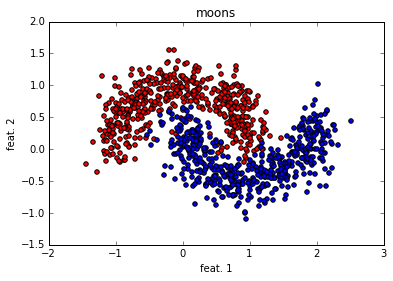

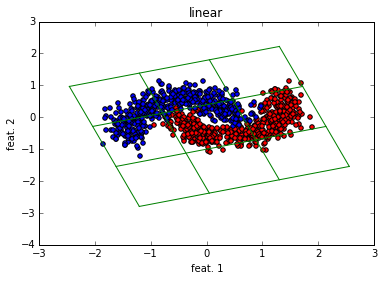

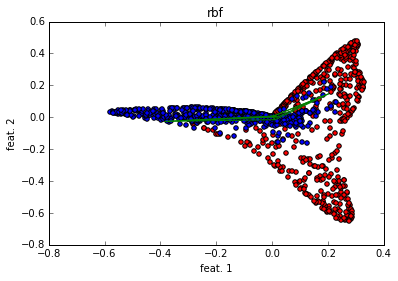

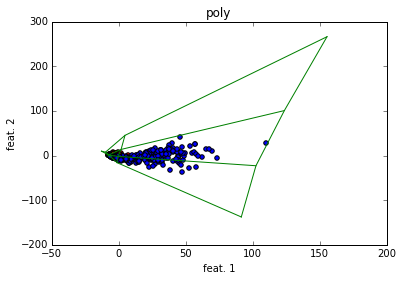

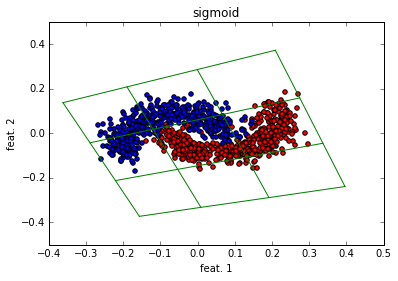

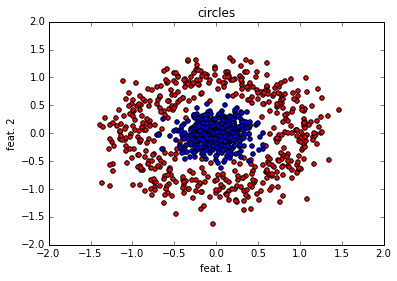

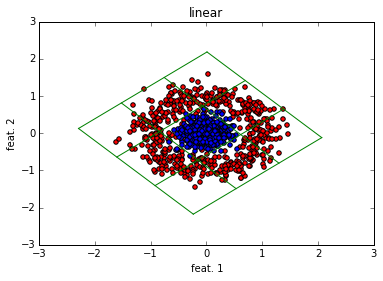

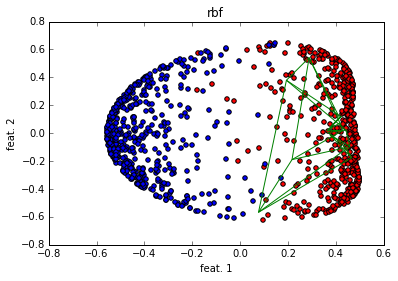

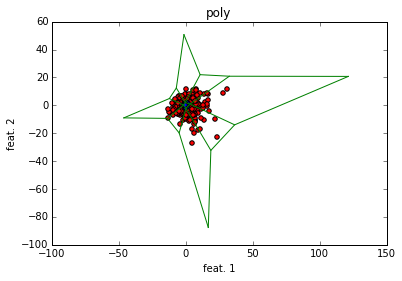

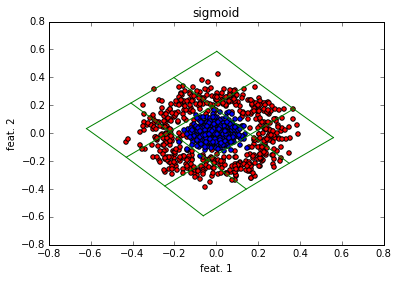

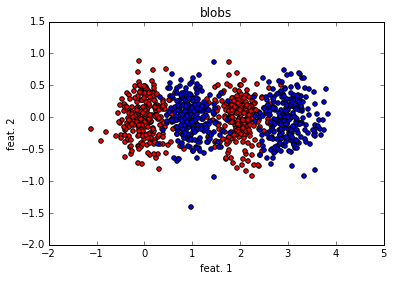

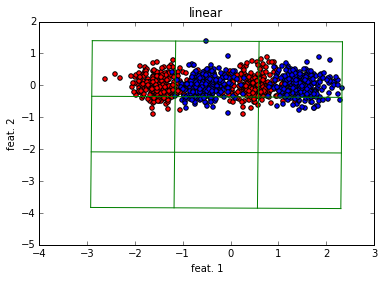

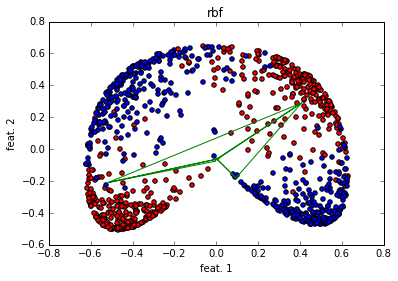

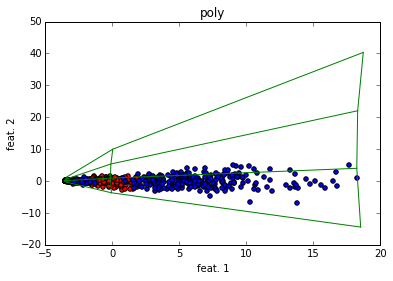

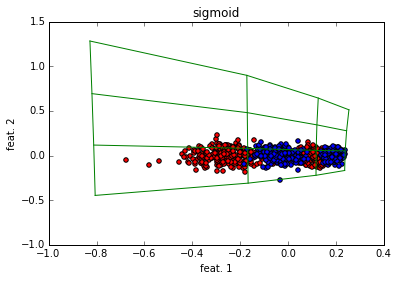

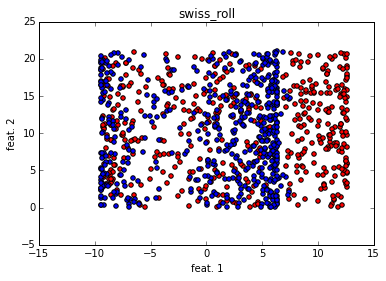

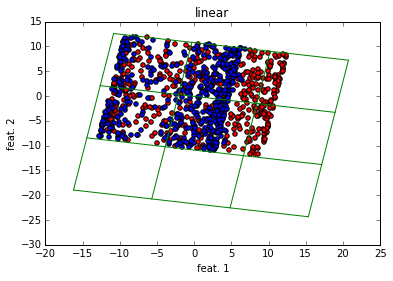

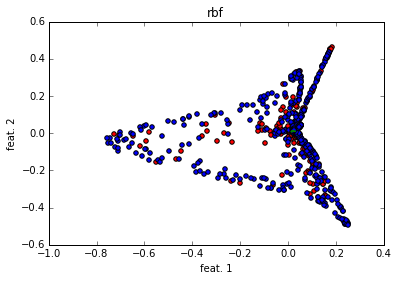

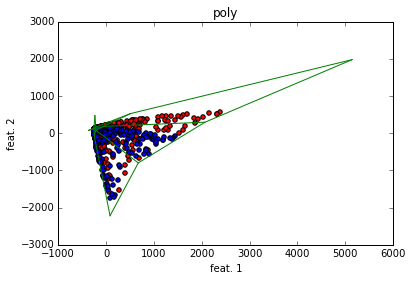

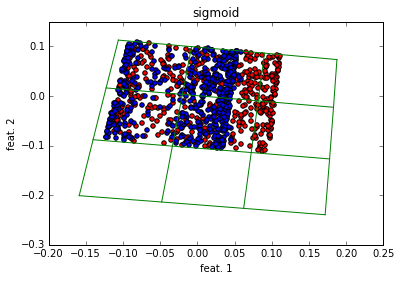

In [17]:
# Use the gammas for which the classification was the best
# to visualize the KPCA projections of the datasets
kernel_opts = {'kernel': '', 'degree': 5}
for key, value in datasets.items(): #key = moons etc.
    x, y = value # datasets
        
    fig = plt.figure()
    ax = scatter_plotDataset(fig,x[:,0:2],y)  # 0:2 i.d.R. hat X eh nur zwei Dim - bei Swiss Rolls wird hier die dritte abgesägt 
    ax.set_title(key)
    for idx_kernel, cKernel in enumerate(kernels):
        #generiere für diesen Datensatz (key=moon) und diesen Kernel (rbf) den array der 20 gammas, oben in dict vordefiniert
        gammas = np.linspace(gamma_ranges[key][cKernel][0],   #z.b. "moons", "rbf", [1e-5,100], adressiere lower bound
                             gamma_ranges[key][cKernel][1],   # upper bound
                             num=n_eval)                      #=20n_eval = 20 # number of gamma values per interval
        
        idx_gamma = np.argmax(scores_overall[key][idx_kernel])      # gibt index von größtem zurück in der 20 gamma Liste  
        c_gamma = gammas[idx_gamma]   # das gamma im array, mit bestem Score
        print('Dataset: %s, Kernel: %s, Best Gamma Value: %.3f, accuracy: %.3f' % 
              (key,cKernel,c_gamma,np.max(scores_overall[key][idx_kernel])))
        kernel_opts['kernel'] = cKernel
        kernel_opts['gamma'] = c_gamma
        kpca = KernelPCA(**kernel_opts)
        x_kpca = kpca.fit_transform(x[:,0:2])   # returns (1.000,491) (n_samles x n_compontens), 
        x_kpca = x_kpca[:,0:2]  # behalte nur die 2 ersten von 491 Dimensionen

        fig = plt.figure()
        ax = scatter_plotDataset(fig,x_kpca,y)
        ax.set_title(cKernel)

        ngrid = 4  # default 20
        xgrid = np.linspace(np.min(x[:]),np.max(x[:]),num=ngrid)
        ygrid = np.linspace(np.min(x[:]),np.max(x[:]),num=ngrid)

        for idx in range(ngrid):
            line = np.concatenate((np.atleast_2d(np.tile(xgrid[idx],ngrid)),
                                   np.atleast_2d(ygrid)),axis=0).T
            line = kpca.transform(line)
            line = line[:,0:2]
            ax.plot(line[:,0],line[:,1],c='g')

        for idx in range(ngrid):
            line = np.concatenate((np.atleast_2d(ygrid),                       
                                   np.atleast_2d(np.tile(xgrid[idx],ngrid))),axis=0).T
            line = kpca.transform(line)
            line = line[:,0:2]
            ax.plot(line[:,0],line[:,1],c='g')